## 0. Bibliotecas

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random
from typing import Callable
import matplotlib.animation as animation


## 1. Funções auxiliares

### 1.1 Função para gerar população de distribuição uniforme e plotá-lo

In [2]:
def rand_population_uniform(m: int, a: list, b: list) -> np.array:
    """
    Gera uma população aleatória com base em uma distribuição uniforme.

    Essa função gera uma população aleatória com `m` indivíduos, utilizando uma distribuição
    uniforme para cada variável do indivíduo. Cada variável é gerada dentro do intervalo definido
    pelos vetores `a` e `b`, onde `a` representa os valores mínimos e `b` representa os valores
    máximos permitidos para cada variável.
    Args:

        - m (int): O número de indivíduos a serem gerados na população.
        - a (list): O vetor de valores mínimos para cada variável do indivíduo.
        - b (list): O vetor de valores máximos para cada variável do indivíduo.

    Returns:
        - samples (np.array): Uma matriz numpy representando a população gerada.

    """
    
    d = len(a)
    _samples = ([a[i] + np.random.random(d) * (b[i] - a[i]) for i in range(d) for _ in range(m)])
    samples = np.array([arr.tolist() for arr in _samples])
    return samples

# Função que plota
def plot_distribution(pop_data: list, title: str) -> None:
    plt.scatter(pop_data[:, 0], pop_data[:, 1], s=10)
    plt.xlim(min(pop_data[:,0])-5, max(pop_data[:,0])+5)
    plt.ylim(min(pop_data[:,1])-5, max(pop_data[:,1])+5)
    plt.xlabel('X Axis')
    plt.ylabel('Y Axis')
    plt.title(title)
    plt.show()
    return None

### 1.2 Funções objetivas

In [53]:
def ackley(x, a=20, b=0.2, c=2*np.pi):
    # Mínimo global fica na origem (0,0)
    d = len(x)
    _sum_1 = np.sum(np.power(x, 2))
    _sum_2 = np.sum(np.cos(c * x))
    result = -a * np.exp(-b * np.sqrt(_sum_1 / d)) - np.exp(_sum_2 / d) + a + np.exp(1)
    return result

def michalewicz(x:list, m:int=10):
    # Para teste: x = [2.20, 1.57] -> result = -1.8011
    result = 0
    for i, v in enumerate(x):
        result -= np.sin(v) * np.sin((i+1) * v**2 / np.pi)**(2 * m)
    return result

In [61]:
def plot_ackley(d):
    """
    Função para plotar função Ackley

    """
    
    def _ackley(x, y, a=20, b=0.2, c=2*np.pi):
        _sum_1 = x**2 + y**2
        _sum_2 = np.cos(c * x) + np.cos(c * y)
        result = -a * np.exp(-b * np.sqrt(_sum_1 / d)) - np.exp(_sum_2 / d) + a + np.exp(1)
        return result

    # Definindo o intervalo dos valores de x e y
    x = np.linspace(-5, 5, 100)
    y = np.linspace(-5, 5, 100)

    # Criando uma grade de pontos para calcular os valores da função
    X, Y = np.meshgrid(x, y)
    Z = _ackley(X, Y)

    # Criando a figura e os eixos
    fig, ax = plt.subplots()

    # Plotando o mapa de calor
    heatmap = ax.pcolormesh(X, Y, Z, cmap='viridis')
    plt.colorbar(heatmap, ax=ax)
    ax.set_title('Ankley Function')
    ax.set_xlabel('x_1')
    ax.set_ylabel('x_2')

    return fig, ax



### 1.3 Função de seleção dos candidatos (a,b,c), mutação e crossover

In [56]:
def select_three_candidates(population: np.array, j: int):
    """
    Seleciona três candidatos aleatórios da população, excluindo o indivíduo de índice j.

    Args:
        - population (np.array): População de indivíduos.
        - j (int): Índice do indivíduo para o qual os candidatos serão selecionados.

    Returns:
        - a (np.array): Primeiro candidato selecionado.
        - b (np.array): Segundo candidato selecionado.
        - c (np.array): Terceiro candidato selecionado.
    """
    candidates_idx = [c for c in range(population.shape[0]) if c!=j]
    idx = np.random.choice(a=candidates_idx, size=3, replace=False)
    a, b, c = population[idx]
    return a, b, c

def mutation(a: list, b: list, c: list, w :float = 0.8 ):
    """
    Realiza a operação de mutação nos vetores a, b e c.

    Args:
        - a (list): Vetor a ser mutado.
        - b (list): Vetor a ser mutado.
        - c (list): Vetor a ser mutado.
        - w (float, opcional): Fator de ponderação para a mutação. O padrão é 0.8. (idealmente entre 0.4 a 1)

    Returns:
        - z (np.array): Vetor resultante da mutação.
    """
    z = a + w*(b-c)
    z = np.array(z)
    return z
    
def crossover(z: np.array, target: np.array, dims: int, cr :float =0.5) -> np.array:
    """
    Realiza a operação de crossover entre os vetores z e target.

    Args:
        - z (np.array): Vetor mutado.
        - target (np.array): Vetor alvo para crossover.
        - dims (int): Número de dimensões dos vetores.
        - cr (float, opcional): Probabilidade de crossover. O padrão é 0.5.

    Returns:
        - new_one (np.array): Vetor resultante do crossover.
    """
    p = np.random.random(size=dims)
    new_one = [z[i] if p[i] < cr else target[i] for i in range(dims)]
    new_one = np.array(new_one)
    return new_one

## 2. Differential Evolution

In [66]:
def differential_evolution(k_max: int, f: Callable, population: np.array, w: float=0.8, cr: float=0.5):
    """
    Executa o algoritmo de otimização Differential Evolution.

    Args:
        - k_max (int): Número máximo de gerações.
        - f (Callable): Função objetivo a ser minimizada. Recebe um vetor como entrada e retorna um escalar.
        - population (np.array): População inicial de indivíduos (vetores) a serem otimizados.
        - w (float, opcional): Fator de ponderação para a etapa de mutação. O padrão é 0.8.
        - cr (float, opcional): Probabilidade de crossover. O padrão é 0.5.

    Returns:
        - best_vector (np.array): Vetor que corresponde à melhor solução encontrada.
        - best_score (float): Valor da função objetivo da melhor solução encontrada.
        - population_list (list): Lista contendo a população em cada geração.

    """
    # Calcula array da função objetiva com população inicial. Salva menor resultado e o vetor associado a este resultado
    y = [f(i) for i in population]
    prev_score = min(y)
    best_vector = population[np.argmin(y)]
    population_list = list()
    # 1o loop: itera sobre gerações
    for k in range(k_max):
        # 2o loop: itera sobre todos os indivíduos
        for j in range(population.shape[0]):
            target = population[j]
            # seleciona 3 candidatos aleatoriamente diferente de target
            a, b, c = select_three_candidates(population, j)
            # Realiza mutação
            z = mutation(a, b, c, w)
            # Realiza crossover
            trial = crossover(z, target, dims=len(population[0]), cr=cr)

            # Compara se o indiívudo mutado/feito crossover é melhor do que o original (target)
            y_trial  = f(trial)
            y_target = f(target)
            if y_trial <  y_target:
                population[j] = trial
                y[j] = y_trial
        # Depois de iterar sobre todos indivíduos, é necessário obter qual indivíduo é o melhor bem como seu score
        best_score = min(y)
        if best_score < prev_score:
            best_vector = population[np.argmin(y)]
            prev_score  = best_score
            print(f'Geração {k+1} - score atual: {best_score:.3f}')
        population_list.append(population.copy())
    return best_vector, best_score, population_list

### 2.1 Executa código

In [67]:
# Reprodutibilidade
random.seed(0)

População inicial - Distribuição uniforme

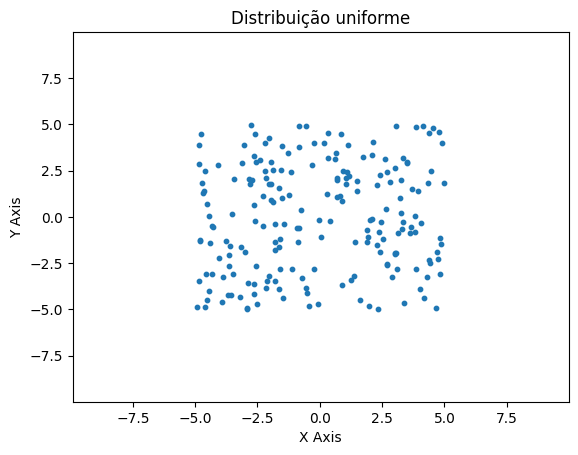

In [68]:
# população inicial
m = 100
a = [-5, -5]
b = [5, 5]

pop = rand_population_uniform(m, a, b)
plot_distribution(pop, title='Distribuição uniforme')

In [69]:
# Definindo parâmetros: número de gerações & função objetiva
k_max = 50
f = ackley
best_vector, best_score, population_list= differential_evolution(k_max, f, population=pop.copy())

Geração 8 - score atual: 0.239
Geração 11 - score atual: 0.154
Geração 14 - score atual: 0.138
Geração 17 - score atual: 0.083
Geração 19 - score atual: 0.031
Geração 24 - score atual: 0.020
Geração 30 - score atual: 0.007
Geração 31 - score atual: 0.005
Geração 33 - score atual: 0.001
Geração 46 - score atual: 0.001
Geração 49 - score atual: 0.000
Geração 50 - score atual: 0.000


### 2.2 Animação em gif

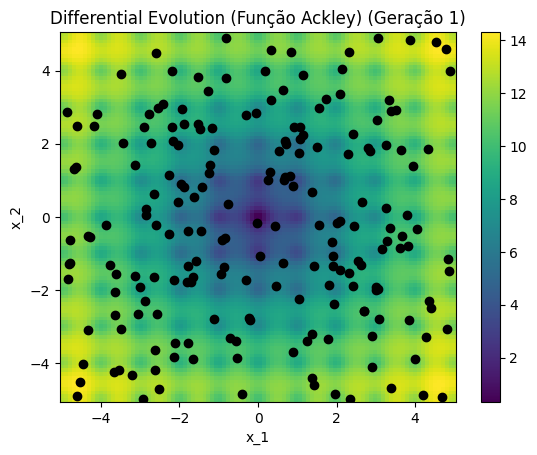

In [72]:
# Chamando a função para obter a figura e os eixos com d = 2
fig, ax = plot_ackley(d=2)

# População de todas gerações
dot_positions = population_list
dots = ax.scatter([], [], color='black', marker='o')

# Função para criar animação em gif
def animate(frame):
    # População de cada geração (frame = geração, nesse caso)
    dots_x, dots_y = zip(*dot_positions[frame])

    # Atualiza pontos
    dots.set_offsets(np.c_[dots_x, dots_y])

    # Plota    
    ax.set_title(f'Differential Evolution (Função Ackley) (Geração {frame+1})')
    ax.set_xlabel('x_1')
    ax.set_ylabel('x_2')

# Cria animação
anim = animation.FuncAnimation(fig, animate, frames=len(dot_positions), interval=100, blit=False)

# Salva animação
anim.save('differential_evolution_ackley.gif', writer='pillow', dpi=500, fps=5)
